In [1]:
suppressPackageStartupMessages({
    library(monocle)
    
    library(RColorBrewer)
    library(dplyr)
    library(ggplot2)
    library(pheatmap)
    library(reshape2)
})

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::clusters’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘ggplot2::Position’ when loading ‘monocle’”

This analysis was made using Monocle version 2.3.5. The source code for Monocle 2.3.5 is available as a supplementary file to Cao et al. 2017 on the Science website. We are working on updating the analysis to the latest version of Monocle.

In [2]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.8 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] reshape2_1.4.2      pheatmap_1.0.8      dplyr_0.7.1        
 [4] RColorBrewer_1.1-2  monocle_2.3.5       DDRTree_0.1.5      
 [7] irlba_2.2.1         VGAM_1.0-3          ggplot2_2.2.1      
[10] Biobase_2.30.0      BiocGenerics_0.16.1 Matrix_1.2-7.1     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           bindr_0.1              plyr_1

In [10]:
system("mkdir -p plots")
system("mkdir -p tables")

In [5]:
# at certain "checkpoints" in this notebook, we save our progress to this RData file
# run this cell to load your progress if you have already reached through one or more checkpoints in the notebook

# IF YOU RUN THIS CELL DO NOT RUN THE CELL BELOW

load("RData/L2.data.summaries.RData")

In [2]:
load("RData/L2.experiment.1.no-cruft.RData")
load("RData/L2.experiment.2.no-cruft.RData")

In [3]:
cds = newCellDataSet(
    cbind(
        exprs(cds.experiment.1),
        exprs(cds.experiment.2)[, with(pData(cds.experiment.2), !is.na(cell.type) & cell.type == "Intestine")]),
    phenoData = new("AnnotatedDataFrame", data = rbind(
        pData(cds.experiment.1)[,
            c("cell", "n.umi", "tissue", "cell.type")],
        pData(cds.experiment.2)[
            with(pData(cds.experiment.2), !is.na(cell.type) & cell.type == "Intestine"),
            c("cell", "n.umi", "tissue", "cell.type")] )),
    featureData = new("AnnotatedDataFrame", data = fData(cds.experiment.1)),
    expressionFamily = negbinomial.size())

In [4]:
pData(cds) %>% group_by(cell.type) %>% summarize(n = n()) %>% arrange(-n)

cell.type,n
Body wall muscle,10508
NA,9184
Germline,5144
Seam cells,3523
Unclassified neurons,2639
Coelomocytes,1358
Non-seam hypodermis,1268
Cholinergic neurons,1015
Ciliated sensory neurons,842
Pharyngeal epithelia,747


In [5]:
cds = estimateSizeFactors(cds)
cds = estimateDispersions(cds)
cds = detectGenes(cds, 0.1)

Warning message:
“Deprecated, use tibble::rownames_to_column() instead.”Warning message in `[<-.data.frame`(`*tmp*`, res$mu == 0, value = structure(list(:
“provided 1 variable to replace 0 variables”Warning message in `[<-.data.frame`(`*tmp*`, res$mu == 0, value = structure(list(:
“provided 1 variable to replace 0 variables”Removing 518 outliers


In [6]:
tissues = setdiff(unique(pData(cds)$tissue),
    c("Intestinal/rectal muscle", "Coelomocytes", "Excretory cells", NA))

cell.types = setdiff(unique(pData(cds)$cell.type),
    c(NA, "Dopaminergic neurons", "Unclassified neurons", "Unclassified glia"))

In [7]:
pData(cds)$cell.type.specific.size.factor =
    (pData(cds) %>% group_by(cell.type) %>% mutate(x = n.umi / median(n.umi)))$x

In [8]:
pData(cds) %>% group_by(cell.type) %>%
    summarize(
        n = n(),
        prop.excluded = sum(cell.type.specific.size.factor < 0.25) / n(),
        n.remaining = sum(cell.type.specific.size.factor >= 0.25)) %>%
    arrange(-prop.excluded)

cell.type,n,prop.excluded,n.remaining
Am/PH sheath cells,421,0.133016627,365
Intestinal/rectal muscle,338,0.088757396,308
Body wall muscle,10508,0.074800152,9722
Seam cells,3523,0.070962248,3273
Germline,5144,0.066096423,4804
Distal tip cells,129,0.062015504,121
Rectum,121,0.057851240,114
Non-seam hypodermis,1268,0.056782334,1196
Intestine,511,0.039138943,491
Pharyngeal gland,271,0.036900369,261


In [9]:
cds = cds[, pData(cds)$cell.type.specific.size.factor >= 0.25]
dim(cds)

Features  Samples 
   20271    40926

In [10]:
norm.expr = sweep(exprs(cds), 2, pData(cds)$Size_Factor, "/")

In [11]:
neuron.norm.expr = sweep(exprs(cds.neurons), 2, pData(cds.neurons)$Size_Factor, "/")

In [12]:
tissue.norm.means = sapply(setdiff(unique(pData(cds)$tissue), NA), function(x) {
    rowMeans(norm.expr[, with(pData(cds), !is.na(tissue) & tissue == x)])
})

rownames(tissue.norm.means) = fData(cds)$symbol

In [13]:
cell.type.norm.means = sapply(setdiff(unique(pData(cds)$cell.type), NA), function(x) {
    rowMeans(norm.expr[, with(pData(cds), !is.na(cell.type) & cell.type == x)])
})

rownames(cell.type.norm.means) = fData(cds)$symbol

In [14]:
# 35 is doublets

pData(cds.neurons)$Cluster = with(pData(cds.neurons), ifelse(
    as.integer(Cluster) < 35, Cluster, ifelse(
    as.integer(Cluster) == 35, 41, as.integer(Cluster) - 1)))

pData(cds.neurons)$Cluster = factor(pData(cds.neurons)$Cluster, levels = 1:41)

In [15]:
neuron.cluster.norm.means = sapply(1:(max(as.integer(unique(pData(cds.neurons)$Cluster))) - 1), function(x) {
    rowMeans(neuron.norm.expr[, with(pData(cds.neurons), as.integer(Cluster) == x)])
})

rownames(neuron.cluster.norm.means) = fData(cds)$symbol
colnames(neuron.cluster.norm.means) = c(
    "AWA",
    "ASG",
    "Cholinergic (3)",
    "RIA",
    "Cluster 5",
    "SDQ/ALN/PLN",
    "BAG",
    "ASI/ASJ",
    "ASEL",
    "Cluster 10",
    "Cholinergic (11)",
    "DVA",
    "Cluster 13",
    "ASER",
    "Cholinergic (15)",
    "Cluster 16",
    "Cluster 17",
    "PVC/PVD",
    "URX/AQR/PQR",
    "Touch receptor",
    "Cluster 21",
    "CAN",
    "Cholinergic (23)",
    "Cholinergic (24)",
    "Cluster 25",
    "Cholinergic (26)",
    "Cluster 27",
    "ASK",
    "Cholinergic (29)",
    "RIC",
    "flp-1(+)",
    "GABAergic",
    "Pharyngeal (33)",
    "Dopaminergic",
    "Cholinergic (35)",
    "Cholinergic (36)",
    "Pharyngeal (37)",
    "AWB/AWC",
    "AFD",
    "Cluster 40")

In [16]:
neuron.clusters = colnames(neuron.cluster.norm.means)

In [17]:
pData(cds.neurons)$cluster.name = ifelse(
    pData(cds.neurons)$Cluster == 41, "Doublets", neuron.clusters[as.integer(pData(cds.neurons)$Cluster)])

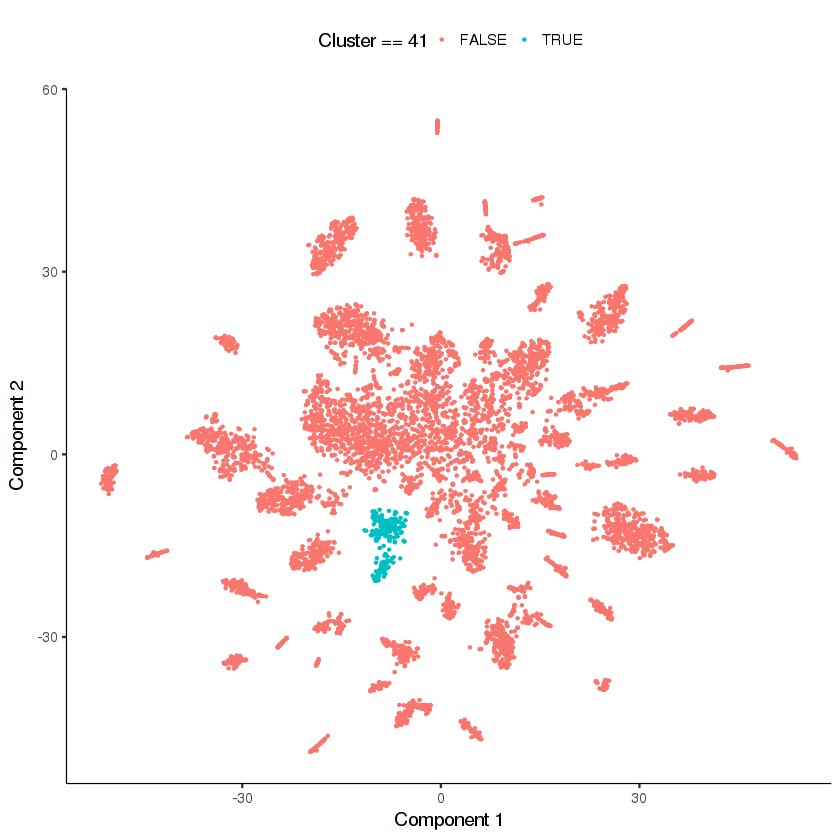

In [18]:
plot_cell_clusters(cds.neurons, color = "Cluster == 41", cell_size = 0.2)

In [19]:
tissue.tpm = sweep(tissue.norm.means, 2, apply(tissue.norm.means, 2, sum), "/") * 1000000
cell.type.tpm = sweep(cell.type.norm.means, 2, apply(cell.type.norm.means, 2, sum), "/") * 1000000
neuron.cluster.tpm = sweep(neuron.cluster.norm.means, 2, apply(neuron.cluster.norm.means, 2, sum), "/") * 1000000

tissue.tpm = tissue.tpm[, tissues]
cell.type.tpm = cell.type.tpm[, cell.types]

In [20]:
save.image("RData/L2.data.summaries.RData")

In [20]:
top.2.tissues.per.gene = do.call(rbind, apply(tissue.tpm, 1, function(x) {
    o = order(x, decreasing=T)
    y = x[o]
    return(list(
        max.tissue = tissues[o[1]],
        max.tissue.expr = unname(y[1]),
        tissue.2 = tissues[o[2]],
        tissue.2.expr = unname(y[2])))
}))

top.2.tissues.per.gene = data.frame(matrix(unlist(
    top.2.tissues.per.gene), nrow=nrow(top.2.tissues.per.gene)),
    row.names = row.names(top.2.tissues.per.gene), stringsAsFactors=F)

names(top.2.tissues.per.gene) = c("max.tissue", "max.tissue.expr", "tissue.2", "tissue.2.expr")
top.2.tissues.per.gene$max.tissue.expr = as.numeric(top.2.tissues.per.gene$max.tissue.expr)
top.2.tissues.per.gene$tissue.2.expr = as.numeric(top.2.tissues.per.gene$tissue.2.expr)

top.2.tissues.per.gene$gene = rownames(top.2.tissues.per.gene)
rownames(top.2.tissues.per.gene) = NULL
top.2.tissues.per.gene = top.2.tissues.per.gene[, c(5, 1:4)]
top.2.tissues.per.gene = mutate(top.2.tissues.per.gene,
    ratio = max.tissue.expr / (tissue.2.expr + 1))

In [21]:
head(top.2.tissues.per.gene)

gene,max.tissue,max.tissue.expr,tissue.2,tissue.2.expr,ratio
aap-1,Gonad,60.10324,Intestine,25.809255,2.241884
aat-1,Pharynx,230.25092,Neurons,16.335719,13.281879
aat-2,Body wall muscle,47.70797,Neurons,17.811412,2.536119
aat-3,Neurons,67.54458,Glia,58.192074,1.141109
aat-4,Intestine,16.17128,Hypodermis,0.212353,13.338753
aat-5,Neurons,217.82001,Body wall muscle,215.532490,1.005946


In [22]:
tissue.specificity.test.res = data.frame(symbol = character(), pval = numeric())

# should take about an hour for all ~20k genes
for (i in rownames(unique(top.2.tissues.per.gene[, c("max.tissue", "tissue.2")]))) {
    i = as.integer(i)
    this.max.tissue = top.2.tissues.per.gene[i, "max.tissue"]
    this.tissue.2 = top.2.tissues.per.gene[i, "tissue.2"]
    
    tmp.df = filter(top.2.tissues.per.gene, max.tissue == this.max.tissue, tissue.2 == this.tissue.2)
    tmp.cds = cds[fData(cds)$symbol %in% tmp.df$gene, with(pData(cds),
        !is.na(tissue) & tissue %in% c(this.max.tissue, this.tissue.2))]
        
    tmp.test.res = differentialGeneTest(tmp.cds,
        fullModelFormulaStr = "~ tissue")
        
    tissue.specificity.test.res = rbind(tissue.specificity.test.res, tmp.test.res[, c("symbol", "pval")])
}

In [23]:
top.2.tissues.per.gene = inner_join(top.2.tissues.per.gene, tissue.specificity.test.res, by = c("gene" = "symbol"))
top.2.tissues.per.gene$qval = p.adjust(top.2.tissues.per.gene$pval, method = "fdr")

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

In [24]:
tissue.specific.genes = filter(top.2.tissues.per.gene, ratio >= 5.0, qval < 0.05) %>%
    filter(gene %in% filter(fData(cds), num_cells_expressed >= 10)$symbol) %>%
    arrange(-sqrt(max.tissue.expr * ratio))

In [25]:
nrow(tissue.specific.genes)
head(tissue.specific.genes)

[1] 3925

gene,max.tissue,max.tissue.expr,tissue.2,tissue.2.expr,ratio,pval,qval
T02B11.3,Glia,16444.112,Hypodermis,12.253017,1240.7825,0,0
nep-17,Intestine,8366.290,Pharynx,3.439974,1884.3107,0,0
npa-1,Intestine,34817.579,Neurons,78.265944,439.2502,0,0
far-8,Glia,9269.549,Neurons,10.988616,773.1959,0,0
K10C2.1,Intestine,6565.492,Neurons,5.848211,958.7164,0,0
C49G7.3,Pharynx,10613.591,Neurons,17.661937,568.7293,0,0


In [26]:
top.2.cell.types.per.gene = do.call(rbind, apply(cell.type.tpm, 1, function(x) {
    o = order(x, decreasing=T)
    y = x[o]
    return(list(
        max.cell.type = cell.types[o[1]],
        max.cell.type.expr = unname(y[1]),
        cell.type.2 = cell.types[o[2]],
        cell.type.2.expr = unname(y[2])))
}))

top.2.cell.types.per.gene = data.frame(matrix(unlist(
    top.2.cell.types.per.gene), nrow=nrow(top.2.cell.types.per.gene)),
    row.names = row.names(top.2.cell.types.per.gene), stringsAsFactors=F)

names(top.2.cell.types.per.gene) = c("max.cell.type", "max.cell.type.expr", "cell.type.2", "cell.type.2.expr")
top.2.cell.types.per.gene$max.cell.type.expr = as.numeric(top.2.cell.types.per.gene$max.cell.type.expr)
top.2.cell.types.per.gene$cell.type.2.expr = as.numeric(top.2.cell.types.per.gene$cell.type.2.expr)

top.2.cell.types.per.gene$gene = rownames(top.2.cell.types.per.gene)
rownames(top.2.cell.types.per.gene) = NULL
top.2.cell.types.per.gene = top.2.cell.types.per.gene[, c(5, 1:4)]
top.2.cell.types.per.gene = mutate(top.2.cell.types.per.gene,
    ratio = max.cell.type.expr / (cell.type.2.expr + 1))

In [27]:
head(top.2.cell.types.per.gene)

gene,max.cell.type,max.cell.type.expr,cell.type.2,cell.type.2.expr,ratio
aap-1,Touch receptor neurons,63.34974,Germline,62.497001,0.9976808
aat-1,Pharyngeal gland,255.23215,Sex myoblasts,205.181741,1.2378989
aat-2,Sex myoblasts,163.59607,Intestinal/rectal muscle,80.016157,2.0193017
aat-3,GABAergic neurons,573.27959,Distal tip cells,178.357100,3.1963027
aat-4,Intestine,16.17128,Coelomocytes,2.159463,5.1183619
aat-5,Other interneurons,397.89573,Cholinergic neurons,343.419569,1.1552646


In [28]:
cell.type.specificity.test.res = data.frame(symbol = character(), pval = numeric())

# should take about an hour for all ~20k genes
for (i in rownames(unique(top.2.cell.types.per.gene[, c("max.cell.type", "cell.type.2")]))) {
    i = as.integer(i)
    this.max.cell.type = top.2.cell.types.per.gene[i, "max.cell.type"]
    this.cell.type.2 = top.2.cell.types.per.gene[i, "cell.type.2"]
    
    tmp.df = filter(top.2.cell.types.per.gene,
        max.cell.type == this.max.cell.type, cell.type.2 == this.cell.type.2)
    tmp.cds = cds[fData(cds)$symbol %in% tmp.df$gene, with(pData(cds),
        !is.na(cell.type) & cell.type %in% c(this.max.cell.type, this.cell.type.2))]
        
    tmp.test.res = differentialGeneTest(tmp.cds,
        fullModelFormulaStr = "~ cell.type")
        
    cell.type.specificity.test.res = rbind(cell.type.specificity.test.res, tmp.test.res[, c("symbol", "pval")])
}

In [29]:
top.2.cell.types.per.gene = inner_join(
    top.2.cell.types.per.gene, cell.type.specificity.test.res, by = c("gene" = "symbol"))
top.2.cell.types.per.gene$qval = p.adjust(top.2.cell.types.per.gene$pval, method = "fdr")

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

In [30]:
cell.type.specific.genes = filter(top.2.cell.types.per.gene, ratio >= 5.0, qval < 0.05) %>%
    filter(gene %in% filter(fData(cds), num_cells_expressed >= 10)$symbol) %>%
    arrange(-sqrt(max.cell.type.expr * ratio))

In [31]:
nrow(cell.type.specific.genes)
head(cell.type.specific.genes)

[1] 1939

gene,max.cell.type,max.cell.type.expr,cell.type.2,cell.type.2.expr,ratio,pval,qval
flp-1,flp-1(+) interneurons,71703.06,Pharyngeal neurons,86.07333,823.4789,1.148437e-197,1.225262e-194
phat-4,Pharyngeal gland,50615.95,Pharyngeal muscle,78.53577,636.3923,4.747507e-197,4.582701e-194
C49G7.3,Pharyngeal gland,78523.98,Pharyngeal muscle,242.73331,322.1717,2.248616e-199,2.532317e-196
npa-1,Intestine,34817.58,Cholinergic neurons,82.84831,415.2448,0.000000e+00,0.000000e+00
mec-17,Touch receptor neurons,24033.03,GABAergic neurons,46.94836,501.2273,1.332482e-180,1.125448e-177
dod-6,Pharyngeal gland,29372.41,Pharyngeal muscle,89.49725,324.5669,1.575504e-163,1.101277e-160


In [32]:
ts.gene.lists = list()
cts.gene.lists = list()

for (tissue in tissues) {
    ts.gene.lists[[tissue]] = as.character(filter(tissue.specific.genes, max.tissue == tissue)$gene)
}

for (cell.type in cell.types) {
    cts.gene.lists[[cell.type]] = as.character(filter(cell.type.specific.genes, max.cell.type == cell.type)$gene)
}

In [33]:
n.ts.genes = sapply(ts.gene.lists, length)
n.cts.genes = sapply(cts.gene.lists, length)

n.ts.genes = data.frame(tissue = names(n.ts.genes), n.specific.genes = n.ts.genes) %>%
    arrange(-n.specific.genes)
n.cts.genes = data.frame(cell.type = names(n.cts.genes), n.specific.genes = n.cts.genes) %>%
    arrange(-n.specific.genes)

n.ts.genes$tissue = factor(n.ts.genes$tissue, levels = n.ts.genes$tissue)
n.cts.genes$cell.type = factor(n.cts.genes$cell.type, levels = n.cts.genes$cell.type)

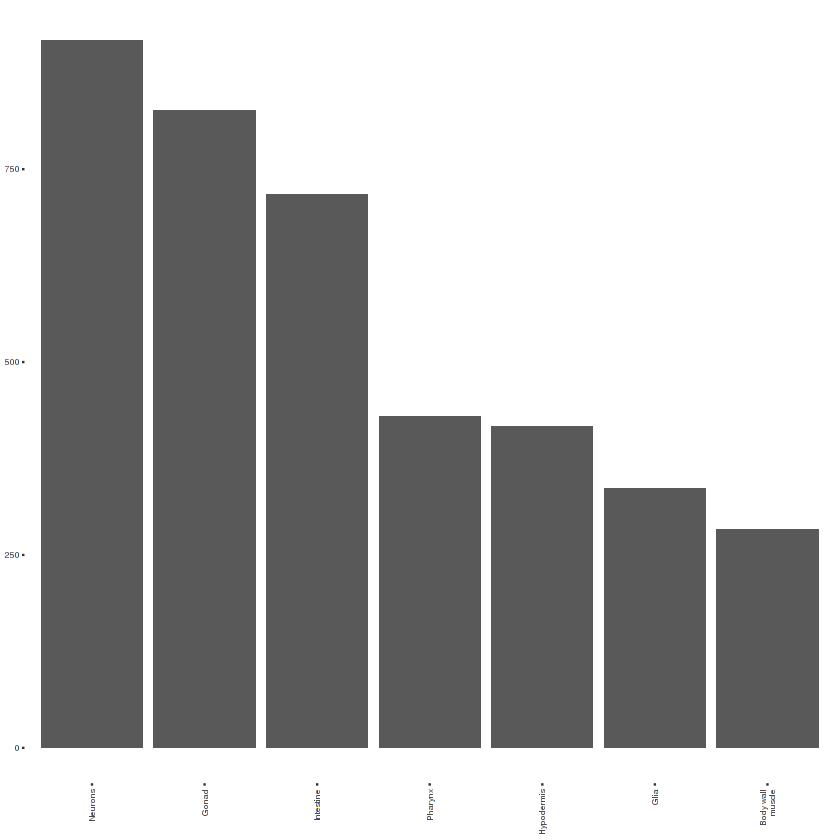

In [6]:
tmp.df = n.ts.genes
tmp.df$tissue = as.character(tmp.df$tissue)
tmp.df$tissue = ifelse(tmp.df$tissue == "Body wall muscle", "Body wall\nmuscle", tmp.df$tissue)
tmp.df$tissue = factor(tmp.df$tissue, levels = tmp.df$tissue)

plot = ggplot(tmp.df, aes(x = tissue, y = n.specific.genes)) +
    geom_bar(stat = "identity") +
    xlab("Tissue") + ylab("# of tissue-specific genes") +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts() +
    theme(
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_text(angle = 90, hjust = 1.0, vjust = 0.5, margin = margin(2, 0, 0, 0)))

show(plot)

ggsave("plots/Fig_3D.pdf",
    device = cairo_pdf, plot = plot, units = "in", width = 1.7, height = 1.1, dpi = 300)

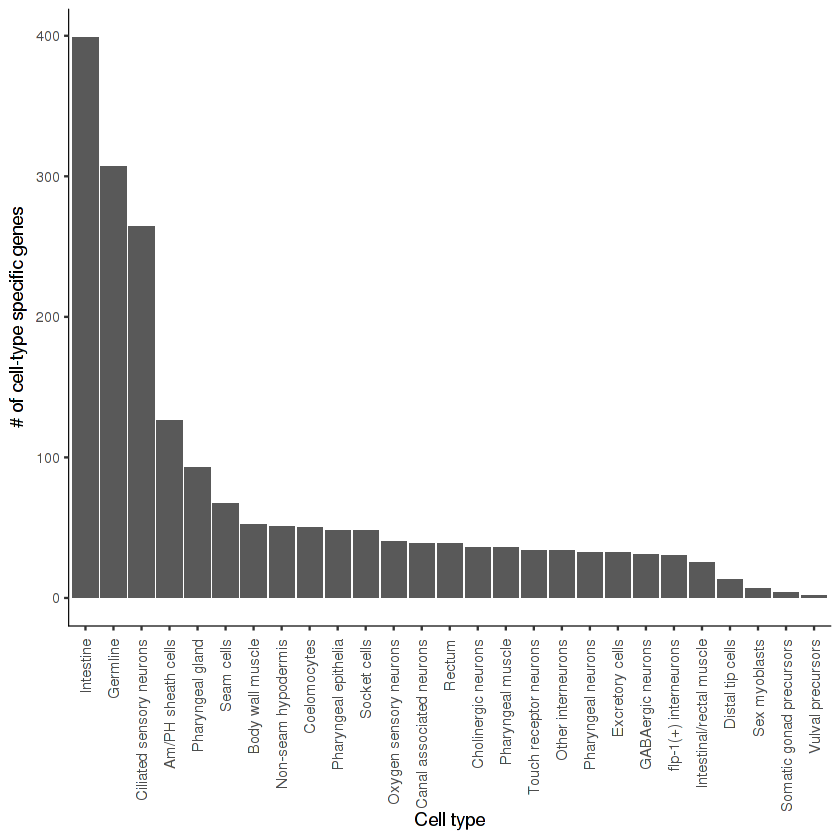

In [7]:
plot = ggplot(n.cts.genes, aes(x = cell.type, y = n.specific.genes)) +
    geom_bar(stat = "identity") +
    xlab("Cell type") + ylab("# of cell-type specific genes") +
    monocle:::monocle_theme_opts() +
    theme(
        axis.title.x = element_text(margin = margin(0, 0, 0, 0)),
        axis.title.y = element_text(margin = margin(0, 5, 0, 0)),
        axis.text.x = element_text(angle = 90, hjust = 1.0, vjust = 0.5, margin = margin(5, 0, 0, 0)))

show(plot)

ggsave("plots/cell-type.specific.gene.counts.pdf",
    device = cairo_pdf, plot = plot, units = "in", width = 5, height = 4, dpi = 300)

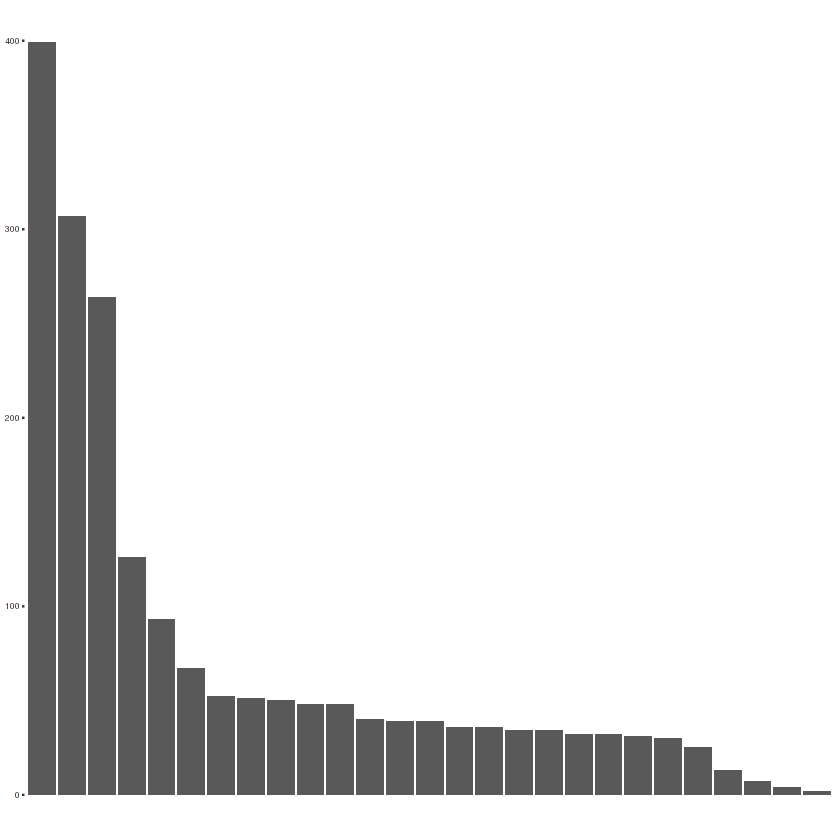

In [8]:
plot = ggplot(n.cts.genes, aes(x = cell.type, y = n.specific.genes)) +
    geom_bar(stat = "identity") +
    xlab("Cell types") + ylab("# of cell-type\nenriched genes") +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts() +
    theme(
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        plot.background = element_rect(fill = "transparent", colour = NA),
        panel.background = element_rect(fill = "transparent", colour = NA))

show(plot)

ggsave("plots/Fig_3E.pdf",
    device = cairo_pdf, plot = plot, units = "in", width = 1.7, height = 0.75, dpi = 300)

In [39]:
save.image("RData/L2.data.summaries.RData")

In [37]:
top.2.neuron.clusters.per.gene = do.call(rbind,
        apply(neuron.cluster.tpm[ts.gene.lists[["Neurons"]],], 1, function(x) {
    o = order(x, decreasing=T)
    y = x[o]
    return(list(
        max.cluster = neuron.clusters[o[1]],
        max.cluster.expr = unname(y[1]),
        cluster.2 = neuron.clusters[o[2]],
        cluster.2.expr = unname(y[2])))
}))

top.2.neuron.clusters.per.gene = data.frame(matrix(unlist(
    top.2.neuron.clusters.per.gene), nrow=nrow(top.2.neuron.clusters.per.gene)),
    row.names = row.names(top.2.neuron.clusters.per.gene), stringsAsFactors=F)

names(top.2.neuron.clusters.per.gene) = c("max.cluster", "max.cluster.expr", "cluster.2", "cluster.2.expr")
top.2.neuron.clusters.per.gene$max.cluster.expr = as.numeric(top.2.neuron.clusters.per.gene$max.cluster.expr)
top.2.neuron.clusters.per.gene$cluster.2.expr = as.numeric(top.2.neuron.clusters.per.gene$cluster.2.expr)

top.2.neuron.clusters.per.gene$gene = rownames(top.2.neuron.clusters.per.gene)
rownames(top.2.neuron.clusters.per.gene) = NULL
top.2.neuron.clusters.per.gene = top.2.neuron.clusters.per.gene[, c(5, 1:4)]
top.2.neuron.clusters.per.gene = mutate(top.2.neuron.clusters.per.gene,
    ratio = max.cluster.expr / (cluster.2.expr + 1))

In [38]:
head(top.2.neuron.clusters.per.gene)

gene,max.cluster,max.cluster.expr,cluster.2,cluster.2.expr,ratio
flp-1,flp-1(+),52660.60,Cluster 13,8040.997,6.548200
egl-21,Cluster 13,16964.78,Cluster 17,16385.516,1.035289
mec-7,Touch receptor,35936.31,PVC/PVD,2473.807,14.520852
egl-3,Pharyngeal (33),20252.72,Cluster 13,20082.113,1.008445
T27C4.1,Cluster 40,20630.73,Cluster 17,19551.680,1.055135
mec-17,Touch receptor,24033.03,Cluster 16,193.080,123.830514


In [39]:
neuron.cluster.specificity.test.res = data.frame(symbol = character(), pval = numeric())

for (i in rownames(unique(top.2.neuron.clusters.per.gene[, c("max.cluster", "cluster.2")]))) {
    i = as.integer(i)
    
    this.max.cluster = top.2.neuron.clusters.per.gene[i, "max.cluster"]
    this.cluster.2 = top.2.neuron.clusters.per.gene[i, "cluster.2"]
    
    tmp.df = filter(top.2.neuron.clusters.per.gene,
        max.cluster == this.max.cluster, cluster.2 == this.cluster.2)

    tmp.cds = cds.neurons[fData(cds.neurons)$symbol %in% tmp.df$gene, with(pData(cds.neurons),
        cluster.name %in% c(this.max.cluster, this.cluster.2))]
        
    tmp.test.res = differentialGeneTest(tmp.cds,
        fullModelFormulaStr = "~ cluster.name")
        
    neuron.cluster.specificity.test.res =
        rbind(neuron.cluster.specificity.test.res, tmp.test.res[, c("symbol", "pval")])
}

In [40]:
top.2.neuron.clusters.per.gene = inner_join(top.2.neuron.clusters.per.gene,
    neuron.cluster.specificity.test.res, by = c("gene" = "symbol"))
top.2.neuron.clusters.per.gene$qval = p.adjust(top.2.neuron.clusters.per.gene$pval, method = "fdr")

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

In [41]:
neuron.cluster.specific.genes = filter(top.2.neuron.clusters.per.gene, ratio >= 5.0, qval < 0.05) %>%
    filter(gene %in% filter(fData(cds), num_cells_expressed >= 10)$symbol) %>%
    arrange(-sqrt(max.cluster.expr * ratio))

In [42]:
nrow(neuron.cluster.specific.genes)
head(neuron.cluster.specific.genes)

[1] 155

gene,max.cluster,max.cluster.expr,cluster.2,cluster.2.expr,ratio,pval,qval
Y57G11B.97,BAG,7540.332,AWA,0.000000,7540.3320,3.902344e-19,9.175513e-18
gcy-17,ASEL,6553.874,AWA,0.000000,6553.8736,1.825544e-14,3.219276e-13
nlp-42,Cholinergic (35),22672.279,Cholinergic (11),30.588556,717.7371,1.842517e-140,8.447939e-138
nlp-17,Cluster 27,27430.770,SDQ/ALN/PLN,57.660373,467.6201,2.128882e-66,3.253641e-64
ZC412.4,CAN,5727.075,Cholinergic (11),2.443933,1662.9461,2.196512e-179,2.014202e-176
flp-17,BAG,51482.154,ASG,366.128386,140.2293,7.898185e-47,6.035530e-45


In [43]:
ncs.gene.lists = list()

for (cluster in neuron.clusters) {
    ncs.gene.lists[[cluster]] = as.character(filter(neuron.cluster.specific.genes, max.cluster == cluster)$gene)
}

In [44]:
head(sort(sapply(ncs.gene.lists, length), decreasing=T), 15)

Cluster 21              CAN   Touch receptor              ASG 
              11               11               10                7 
         PVC/PVD              ASK              AWA             ASEL 
               7                7                6                6 
     URX/AQR/PQR             ASER Cholinergic (15)       Cluster 16 
               6                5                5                5 
Cholinergic (29)         flp-1(+)              BAG 
               5                5                4

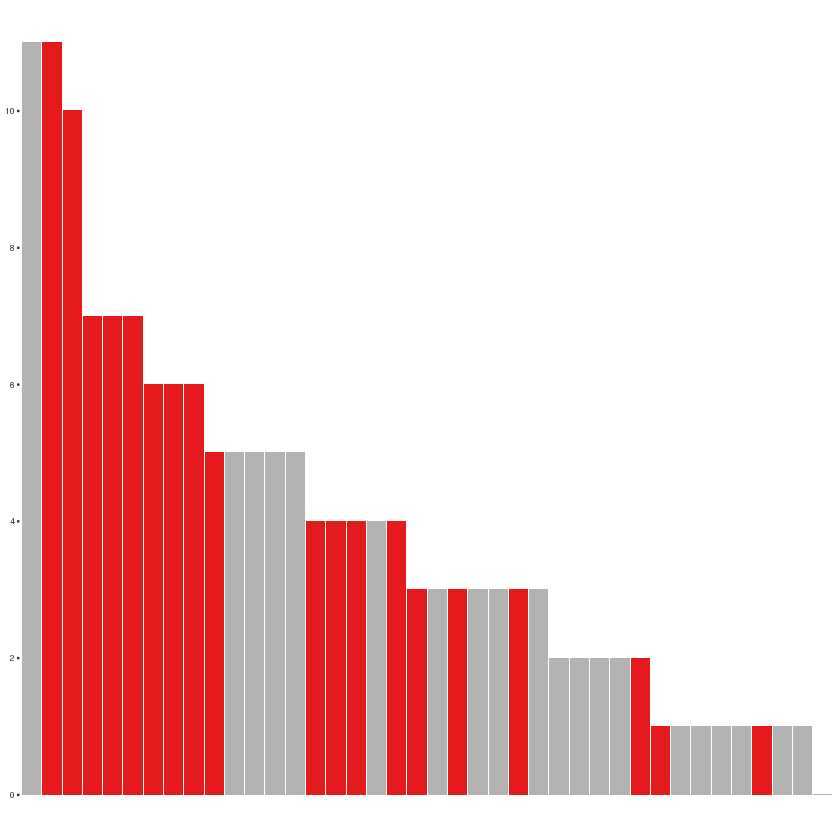

In [9]:
tmp.df = data.frame(
    cluster = names(ncs.gene.lists),
    n.specific.genes = sapply(ncs.gene.lists, length),
    identified = !grepl("Cluster|[()]", names(ncs.gene.lists))) %>%
    arrange(-n.specific.genes)

tmp.df$cluster = factor(tmp.df$cluster, levels = tmp.df$cluster)

plot = ggplot(tmp.df, aes(x = cluster, y = n.specific.genes, fill = identified)) +
    geom_bar(stat = "identity") +
    scale_y_continuous(breaks = seq(0, 14, 2)) +
    scale_fill_manual(values = c("grey70", "#E41A1C")) +
    xlab("Cluster") + ylab("# of cluster\nspecific genes") +
    guides(fill = F) +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts() +
    theme(
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank())

show(plot)

ggsave("plots/Fig_4D.pdf",
    device = cairo_pdf, plot = plot, units = "in", width = 2.0, height = 1.0)

In [47]:
binary.gene.tissue.expr.mat = ifelse(sweep(tissue.tpm, 1, apply(tissue.tpm, 1, max), "/") >= 0.1, 1, 0)
binary.gene.tissue.expr.mat = binary.gene.tissue.expr.mat[
    rownames(binary.gene.tissue.expr.mat) %in% filter(fData(cds), num_cells_expressed >= 20)$symbol &
    apply(tissue.tpm, 1, max) >= 10.0,]

nrow(binary.gene.tissue.expr.mat)

[1] 11720

In [48]:
binary.gene.cell.type.expr.mat = ifelse(sweep(cell.type.tpm, 1, apply(cell.type.tpm, 1, max), "/") >= 0.1, 1, 0)
binary.gene.cell.type.expr.mat = binary.gene.cell.type.expr.mat[
    rownames(binary.gene.cell.type.expr.mat) %in% filter(fData(cds), num_cells_expressed >= 20)$symbol &
    apply(cell.type.tpm, 1, max) >= 10.0,]

nrow(binary.gene.cell.type.expr.mat)

[1] 12771

In [49]:
binary.gene.neuron.cluster.expr.mat =
    ifelse(sweep(neuron.cluster.tpm, 1, apply(neuron.cluster.tpm, 1, max), "/") >= 0.1, 1, 0)
binary.gene.neuron.cluster.expr.mat = binary.gene.neuron.cluster.expr.mat[
    rownames(binary.gene.neuron.cluster.expr.mat) %in% ts.gene.lists[["Neurons"]],]

nrow(binary.gene.neuron.cluster.expr.mat)

[1] 917

In [50]:
ct.selective.subset = binary.gene.cell.type.expr.mat[
    apply(binary.gene.cell.type.expr.mat, 1, sum) > 1 &
    apply(binary.gene.cell.type.expr.mat, 1, sum) <= 7,]

dim(ct.selective.subset)

[1] 4934   27

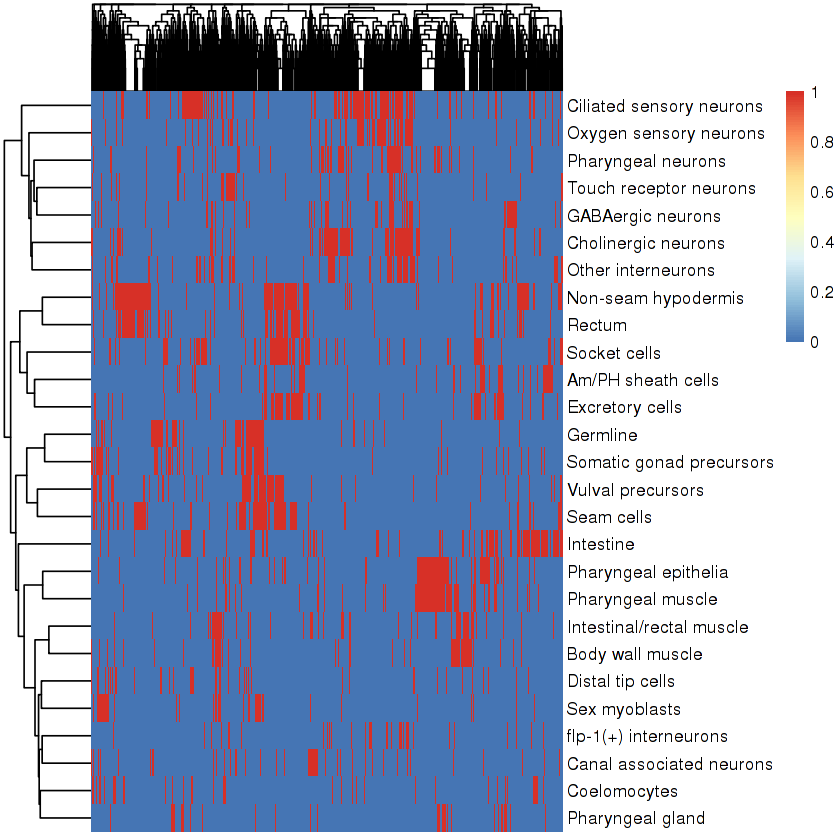

In [51]:
pheatmap(t(ct.selective.subset), scale = "none", show_rownames = T, show_colnames = F)

In [52]:
cell.type.groups = list()

cell.type.groups[["Still in cell cycle"]] =
    c("Seam cells", "Vulval precursors", "Somatic gonad precursors", "Germline", "Sex myoblasts")

In [53]:
ct.selective.gene.lists = list()

ct.selective.gene.lists[["Pharyngeal muscle and epithelia"]] = unique(c(
    cts.gene.lists[["Pharyngeal muscle"]], cts.gene.lists[["Pharyngeal epithelia"]],
    rownames(binary.gene.cell.type.expr.mat)[
        apply(binary.gene.cell.type.expr.mat, 1, sum) <= 3 &
        apply(binary.gene.cell.type.expr.mat[, c("Pharyngeal muscle", "Pharyngeal epithelia")], 1, sum) == 2
    ]))

ct.selective.gene.lists[["Non-seam hypodermis and rectum"]] = unique(c(
    cts.gene.lists[["Non-seam hypodermis"]], cts.gene.lists[["Rectum"]],
    rownames(binary.gene.cell.type.expr.mat)[
        apply(binary.gene.cell.type.expr.mat, 1, sum) <= 3 &
        apply(binary.gene.cell.type.expr.mat[, c("Non-seam hypodermis", "Rectum")], 1, sum) == 2 &
        binary.gene.cell.type.expr.mat[, "Seam cells"] == 0
    ]))

ct.selective.gene.lists[["Non-pharyngeal epithelia"]] = unique(c(
    rownames(binary.gene.cell.type.expr.mat)[
        apply(binary.gene.cell.type.expr.mat[, c(
            "Non-seam hypodermis", "Rectum", "Vulval precursors",
            "Seam cells", "Socket cells", "Excretory cells")], 1, sum) >= 5 &
        apply(binary.gene.cell.type.expr.mat[, setdiff(cell.types, c(
            "Non-seam hypodermis", "Rectum", "Vulval precursors",
            "Seam cells", "Socket cells", "Excretory cells"))], 1, sum) <= 2
    ]))

ct.selective.gene.lists[["Still in cell cycle"]] = unique(c(
    rownames(binary.gene.cell.type.expr.mat)[
        apply(binary.gene.cell.type.expr.mat[, c(
            "Germline", "Somatic gonad precursors",
            "Seam cells", "Vulval precursors", "Sex myoblasts")], 1, sum) >= 4 &
        apply(binary.gene.cell.type.expr.mat[, setdiff(cell.types, c(
            "Germline", "Somatic gonad precursors",
            "Seam cells", "Vulval precursors", "Sex myoblasts"))], 1, sum) <= 2
    ]))

In [54]:
sapply(ct.selective.gene.lists, length)

Pharyngeal muscle and epithelia  Non-seam hypodermis and rectum 
                            275                             284 
       Non-pharyngeal epithelia             Still in cell cycle 
                            211                             145

In [55]:
nc.selective.subset = binary.gene.neuron.cluster.expr.mat[
    apply(binary.gene.neuron.cluster.expr.mat, 1, sum) > 1 &
    apply(binary.gene.neuron.cluster.expr.mat, 1, sum) <= 10,]

dim(nc.selective.subset)

[1] 544  40

In [56]:
sum(apply(binary.gene.neuron.cluster.expr.mat, 1, sum) <= 10) / nrow(binary.gene.neuron.cluster.expr.mat)

[1] 0.7208288

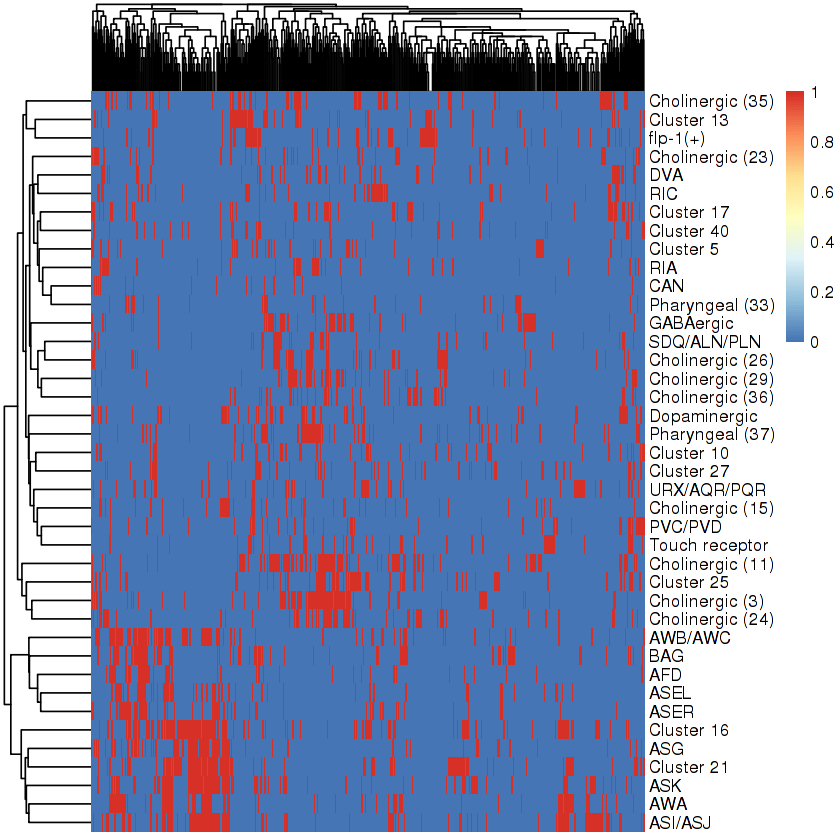

In [57]:
pheatmap(t(nc.selective.subset), scale = "none", show_rownames = T, show_colnames = F)

In [58]:
broadly.expressed.genes = rownames(tissue.tpm)[
    apply(tissue.tpm, 1, max) >= 100.0 &
    apply(tissue.tpm, 1, min) >= 0.2 * apply(tissue.tpm, 1, max)
]

broadly.expressed.genes = broadly.expressed.genes[
    !grepl("^his-|^rps-|^rpl-|^rla-", broadly.expressed.genes)]

length(broadly.expressed.genes)

[1] 653

In [60]:
save.image("RData/L2.data.summaries.RData")

In [61]:
save(list = c(
    "cds.experiment.1", "cds.experiment.2", "cds.neurons",
    "get.gene.id", "expresses.gene", "plot.expr",
    "plot.tissues", "plot.cell.types", "plot.fine.grained.neuron.types",
    "tissues", "cell.types", "neuron.clusters",
    "tissue.norm.means", "cell.type.norm.means", "neuron.cluster.norm.means",
    "tissue.tpm", "cell.type.tpm", "neuron.cluster.tpm",
    "tissue.specific.genes", "cell.type.specific.genes", "neuron.cluster.specific.genes",
    "ts.gene.lists", "cts.gene.lists", "ncs.gene.lists",
    "binary.gene.tissue.expr.mat", "binary.gene.cell.type.expr.mat", "binary.gene.neuron.cluster.expr.mat",
    "ct.selective.gene.lists", "broadly.expressed.genes",
    "top.2.cell.types.per.gene"),
    file = "RData/L2.data.summaries.no-cruft.RData")

In [13]:
tmp.df = as.data.frame(tissue.tpm)
tmp.df$symbol = rownames(tmp.df)
colnames(tmp.df) = gsub(" ", "_", colnames(tmp.df))
tmp.df = tmp.df %>% inner_join(fData(cds.experiment.1) %>% select(gene_id, symbol), by = "symbol")
tmp.df = tmp.df[, c(ncol(tmp.df), ncol(tmp.df)-1, 1:(ncol(tmp.df)-2))]

head(tmp.df)

write.table(tmp.df, file = "tables/tissue.tpm.tsv",
    sep = "\t", quote = F, row.names = F, col.names = T)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

gene_id,symbol,Neurons,Gonad,Hypodermis,Pharynx,Body_wall_muscle,Glia,Intestine
WBGene00000001,aap-1,20.10723,60.103240,14.594124,14.65679771,7.42570647,18.018642,25.809255
WBGene00000002,aat-1,16.33572,7.073051,6.134333,230.25091723,0.20551670,1.390876,1.025635
WBGene00000003,aat-2,17.81141,5.870587,6.336165,12.71142265,47.70797402,3.220114,0.000000
WBGene00000004,aat-3,67.54458,7.921189,14.893854,9.63209846,53.55527318,58.192074,5.056305
WBGene00000005,aat-4,0.00000,0.107937,0.212353,0.07872082,0.05928501,0.000000,16.171277
WBGene00000006,aat-5,217.82001,0.771206,5.409747,55.13823844,215.53248981,0.000000,2.823343


In [14]:
tmp.df = as.data.frame(cell.type.tpm)
tmp.df$symbol = rownames(tmp.df)
colnames(tmp.df) = gsub(" ", "_", colnames(tmp.df))
tmp.df = tmp.df %>% inner_join(fData(cds.experiment.1) %>% select(gene_id, symbol), by = "symbol")
tmp.df = tmp.df[, c(ncol(tmp.df), ncol(tmp.df)-1, 1:(ncol(tmp.df)-2))]

head(tmp.df)

write.table(tmp.df, file = "tables/cell.type.tpm.tsv",
    sep = "\t", quote = F, row.names = F, col.names = T)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

gene_id,symbol,Germline,Intestinal/rectal_muscle,Coelomocytes,Ciliated_sensory_neurons,Seam_cells,Non-seam_hypodermis,Pharyngeal_epithelia,Touch_receptor_neurons,⋯,Oxygen_sensory_neurons,Somatic_gonad_precursors,flp-1(+)_interneurons,Canal_associated_neurons,Pharyngeal_gland,Sex_myoblasts,Excretory_cells,Socket_cells,Rectum,Intestine
WBGene00000001,aap-1,62.4970008,10.205136,23.522258,2.60164,17.6849361,6.125070,19.126607,63.34974,⋯,34.100314,38.82104,34.322845,15.49667,2.756256,33.44604,11.55090,17.451509,0.00000,25.809255
WBGene00000002,aat-1,0.0000000,0.000000,73.422178,16.97630,4.4585387,7.957491,190.043766,0.00000,⋯,3.173948,87.77354,0.000000,6.71949,255.232150,205.18174,0.00000,0.000000,40.75095,1.025635
WBGene00000003,aat-2,0.0000000,80.016157,26.607997,0.00000,0.8205818,8.642118,9.406249,11.97605,⋯,78.474267,74.52351,3.885366,0.00000,20.001143,163.59607,0.00000,8.374096,4.06296,0.000000
WBGene00000004,aat-3,0.2486504,52.852916,8.283492,27.34430,14.2303936,16.588887,0.000000,10.96708,⋯,65.493464,54.98244,58.661807,0.00000,4.683885,79.58768,43.39287,76.614359,44.35431,5.056305
WBGene00000005,aat-4,0.1184072,2.012866,2.159463,0.00000,0.3169399,0.000000,0.000000,0.00000,⋯,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,16.171277
WBGene00000006,aat-5,0.5962730,30.176841,13.612837,36.75811,4.6388102,5.132860,13.522102,152.18600,⋯,105.023762,0.00000,249.524718,0.00000,0.000000,105.25522,14.67423,0.000000,1.35432,2.823343


In [52]:
tmp.df = as.data.frame(neuron.cluster.tpm)
tmp.df$symbol = rownames(tmp.df)
colnames(tmp.df) = gsub(" ", "_", colnames(tmp.df))
tmp.df = tmp.df %>% inner_join(fData(cds.experiment.1) %>% select(gene_id, symbol), by = "symbol")
tmp.df = tmp.df[, c(ncol(tmp.df), ncol(tmp.df)-1, 1:(ncol(tmp.df)-2))]

head(tmp.df)

write.table(tmp.df, file = "tables/neuron.cluster.tpm.tsv",
    sep = "\t", quote = F, row.names = F, col.names = T)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

gene_id,symbol,AWA,ASG,Cholinergic_(3),RIA,Cluster_5,SDQ/ALN/PLN,BAG,ASI/ASJ,⋯,flp-1(+),GABAergic,Pharyngeal_(33),Dopaminergic,Cholinergic_(35),Cholinergic_(36),Pharyngeal_(37),AWB/AWC,AFD,Cluster_40
WBGene00000001,aap-1,0,0.0000,12.92240,0.0000,0.0000,65.003723,0.00000,0.0000,⋯,38.81211,0.000000,0.0000,0.00000,0,35.42466,0.00000,0,0.0000,0.000
WBGene00000002,aat-1,0,0.0000,61.27338,0.0000,0.0000,6.050339,0.00000,0.0000,⋯,0.00000,0.000000,0.0000,0.00000,0,0.00000,135.55255,0,0.0000,0.000
WBGene00000003,aat-2,0,0.0000,16.23377,0.0000,0.0000,112.898811,87.62450,0.0000,⋯,44.09488,7.866273,0.0000,0.00000,0,0.00000,23.35248,0,0.0000,0.000
WBGene00000004,aat-3,0,0.0000,22.67254,62.8003,0.0000,65.316529,59.70149,150.2172,⋯,43.08277,611.498230,0.0000,110.23241,0,77.92313,100.29518,0,0.0000,0.000
WBGene00000005,aat-4,0,0.0000,0.00000,0.0000,0.0000,0.000000,0.00000,0.0000,⋯,0.00000,0.000000,0.0000,0.00000,0,0.00000,0.00000,0,0.0000,0.000
WBGene00000006,aat-5,0,107.6658,163.22393,544.9071,396.5175,75.188140,134.46282,0.0000,⋯,211.30163,356.962829,106.5587,48.75433,0,846.30687,186.82161,0,498.7583,875.996


In [3]:
tmp.df = top.2.tissues.per.gene %>%
    filter(gene %in% filter(fData(cds), num_cells_expressed >= 10)$symbol) %>%
    arrange(qval, -ratio)

tmp.df$max.tissue = gsub(" ", "_", tmp.df$max.tissue)
tmp.df$tissue.2 = gsub(" ", "_", tmp.df$tissue.2)

tmp.df = tmp.df %>% inner_join(fData(cds.experiment.1) %>% select(gene_id, symbol), by = c("gene" = "symbol"))
tmp.df = tmp.df[, c(9, 1, 2, 3, 4, 5, 6, 7, 8)]
colnames(tmp.df)[2] = "symbol"

head(tmp.df)

write.table(tmp.df, file = "tables/tissue.enriched.genes.tsv",
    sep = "\t", quote = F, row.names = F, col.names = T)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

gene_id,symbol,max.tissue,max.tissue.expr,tissue.2,tissue.2.expr,ratio,pval,qval
WBGene00010070,nep-17,Intestine,8366.290,Pharynx,3.439974,1884.3107,0,0
WBGene00020155,T02B11.3,Glia,16444.112,Hypodermis,12.253017,1240.7825,0,0
WBGene00019617,K10C2.1,Intestine,6565.492,Neurons,5.848211,958.7164,0,0
WBGene00011708,T11B7.5,Glia,1931.194,Hypodermis,1.104066,917.8393,0,0
WBGene00001392,far-8,Glia,9269.549,Neurons,10.988616,773.1959,0,0
WBGene00001710,grl-1,Glia,3492.055,Hypodermis,4.529193,631.5668,0,0


In [4]:
tmp.df = top.2.cell.types.per.gene %>%
    filter(gene %in% filter(fData(cds), num_cells_expressed >= 10)$symbol) %>%
    arrange(qval, -ratio)

tmp.df$max.cell.type = gsub(" ", "_", tmp.df$max.cell.type)
tmp.df$cell.type.2 = gsub(" ", "_", tmp.df$cell.type.2)

tmp.df = tmp.df %>% inner_join(fData(cds.experiment.1) %>% select(gene_id, symbol), by = c("gene" = "symbol"))
tmp.df = tmp.df[, c(9, 1, 2, 3, 4, 5, 6, 7, 8)]
colnames(tmp.df)[2] = "symbol"

head(tmp.df)

write.table(tmp.df, file = "tables/cell.type.enriched.genes.tsv",
    sep = "\t", quote = F, row.names = F, col.names = T)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

gene_id,symbol,max.cell.type,max.cell.type.expr,cell.type.2,cell.type.2.expr,ratio,pval,qval
WBGene00003786,npa-1,Intestine,34817.579,Cholinergic_neurons,82.848315,415.24483,0.000000e+00,0.000000e+00
WBGene00006404,tag-10,Intestine,1932.948,Body_wall_muscle,6.291569,265.09363,0.000000e+00,0.000000e+00
WBGene00019160,H05L03.3,flp-1(+)_interneurons,33283.428,Cholinergic_neurons,171.686541,192.73898,0.000000e+00,0.000000e+00
WBGene00000733,col-160,Non-seam_hypodermis,2521.983,Seam_cells,61.220298,40.53312,1.828043e-322,9.264077e-319
WBGene00000583,cof-2,Coelomocytes,1370.146,Body_wall_muscle,7.814658,155.43946,7.758911e-298,3.145618e-294
WBGene00019563,K09C6.9,Am/PH_sheath_cells,6411.889,Non-seam_hypodermis,4.833066,1099.23143,4.792482e-289,1.619140e-285


In [53]:
tmp.df = top.2.neuron.clusters.per.gene %>%
    filter(gene %in% filter(fData(cds), num_cells_expressed >= 10)$symbol) %>%
    arrange(qval, -max.cluster.expr)

tmp.df$max.cluster = gsub(" ", "_", tmp.df$max.cluster)
tmp.df$cluster.2 = gsub(" ", "_", tmp.df$cluster.2)

tmp.df = tmp.df %>% inner_join(fData(cds.experiment.1) %>% select(gene_id, symbol), by = c("gene" = "symbol"))
tmp.df = tmp.df[, c(9, 1, 2, 3, 4, 5, 6, 7, 8)]
colnames(tmp.df)[2] = "symbol"

head(tmp.df)

write.table(tmp.df, file = "tables/neuron.cluster.enriched.genes.tsv",
    sep = "\t", quote = F, row.names = F, col.names = T)

Warning message in inner_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining character vector and factor, coercing into character vector”

gene_id,symbol,max.cluster,max.cluster.expr,cluster.2,cluster.2.expr,ratio,pval,qval
WBGene00013885,ZC412.4,CAN,5727.075,Cholinergic_(11),2.4439332,1662.9461,2.196512e-179,2.014202e-176
WBGene00013588,nlp-42,Cholinergic_(35),22672.279,Cholinergic_(11),30.5885557,717.7371,1.842517e-140,8.447939e-138
WBGene00022191,Y71H2B.1,CAN,2621.910,Cholinergic_(11),0.9137047,1370.0702,2.537769e-95,7.757113e-93
WBGene00011644,T09B9.3,Cluster_21,3836.121,Cholinergic_(11),4.1024631,751.8175,9.539623e-78,2.186959e-75
WBGene00003178,mec-17,Touch_receptor,24033.028,Cluster_16,193.0800124,123.8305,9.461794e-76,1.735293e-73
WBGene00003755,nlp-17,Cluster_27,27430.770,SDQ/ALN/PLN,57.6603727,467.6201,2.128882e-66,3.253641e-64
